# Growth and seasonal component analysis

We look at the Mauna Loa observatory measurments of atmospheric $CO_2$, more specifically, the monthly dataset from 1958 to 2019, trying to understand the long-term growth and the monthly seasonality. The dataset can be downloaded [here](http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo).

In [2]:
# standard imports
%matplotlib inline

from datetime import timedelta
import calendar
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-whitegrid')

# utility function
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize

### Loading the data

In [3]:
data = pd.read_csv('monthly_in_situ_co2_mlo.csv', header=56)

# missing data is marked as -99.99
data = data.replace(to_replace=-99.99, value=np.nan)
data = data.dropna().reset_index(drop=True)

data.columns = ["year", "month", "_1", "_1", "CO2", "_3", "_4", "_5", "_6", "_7"]
data = data[['year', 'month', 'CO2']]

data = data.assign(date = data.apply(
    lambda row: pd.Timestamp(year=int(row.year), month=int(row.month), day=1), 
    axis=1))

data = data.assign(month_i = data.date.dt.year * 12 + data.date.dt.month)
data = data.assign(month_i = data.month_i - data.month_i.min())
data = data.sort_values('date').reset_index(drop=True)

data.head(5)

,year,month,CO2,date,month_i
0,1958,3,315.70,1958-03-01,0
1,1958,4,317.45,1958-04-01,1
2,1958,5,317.51,1958-05-01,2
3,1958,7,315.86,1958-07-01,4
4,1958,8,314.93,1958-08-01,5


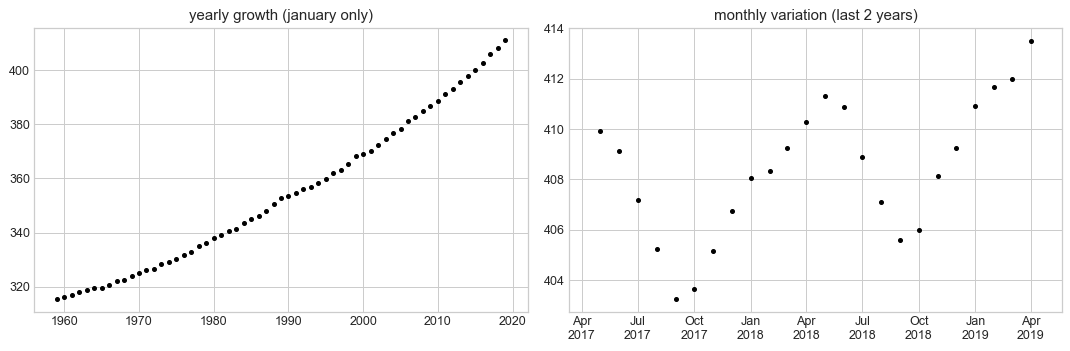

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), dpi=90)
ax1.scatter(data[data.month == 1].year, data[data.month == 1].CO2, marker='.', c='k')
ax1.set(title='yearly growth (january only)')
ax2.scatter(data.date[-24:], data.CO2[-24:], marker='.', c='k')
ax2.set(title='monthly variation (last 2 years)')
ax2.xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
fig.tight_layout()
None

## Model

We use a two-component model:

$$ CO_2 = \overline{CO_2} g(t) + p(m) $$

where $t$ is the number ofmonths since the first one (March 1958), scaled from 0 to 1, and $m$ is the month of the year, from 0 to 11.

* (Positive) Exponential growth $g$:

$$ g(t) = g_0 + a e^{b t} $$

$$ g_0 \sim \text{Normal}(0, 1) $$

$$ a \sim \text{Exponential}(1) $$

$$ b \sim \text{Normal}(0, 1), b > 0 $$

The purpose of this model is to demonstrate a way to use Fourier decomposition with Bayesian inference, so for the growth component we will just use this simple explonential growth model.

* Periodical component $p$ modeled with a Fourier transorm:

$$ p(m) = \sum_{k=0}^{11}\big( {S_k \sin{\frac{2 \pi k m}{12}} + C_k \cos{\frac{2 \pi k m}{12}  } }\big) $$

We will let the model determine the coefficients, but assume that for each mode the two coefficients $S_k, C_k$ are covariate. The covariance will be drawn them from a hyper-prior:

$$ \big({ S_k, C_k }\big) \sim \text{Normal}(0, \text{cholesky_covariance} = K) $$

$$ K \sim \text{LKJCholesky}(\eta=1, \sigma \sim \text{Exponential}(1/2) ) $$

* Finally, for the inference, we will use normal likelihood:

$$ \text{observed} \sim \text{Normal}(CO_2, \sigma) $$

$$ \sigma \sim \text{HalfCauchy}(1) $$

In [5]:
with pm.Model() as m1:
    # exponential growth
    g0 = pm.Normal('g0', mu=0, sd=1)
    a = pm.Exponential('a', lam=1.)
    b = pm.Bound(pm.Normal, lower=0)('b', mu=0, sd=1)

    t = data.month_i.values / data.month_i.max()
    g = pm.Deterministic('g', g0 + a * pm.math.exp(b * t))

    # monthly seasonality
    sk = pm.Normal('sk', mu=0, sd=1, shape=12)
    ck = pm.Normal('ck', mu=0, sd=1, shape=12)

    comps = []
    p = 0
    for k in range(12):
        phi = 2 * np.pi * k * np.arange(0, 13) / 12
        sin_comp = sk[k] * pm.math.sin(phi)
        cos_comp = ck[k] * pm.math.cos(phi)
        comps.append(sin_comp)
        comps.append(cos_comp)
        p = p + sin_comp + cos_comp

    p = pm.Deterministic('p', p)

    # the individual components
    comps = pm.Deterministic('components', pm.math.stack(comps))

    # putting it together
    co2 = pm.Deterministic(
        'co2',
        data.CO2.mean() * g
        + p[data.month.values - 1]
    )

    # inference
    sigma = pm.HalfCauchy('sigma', beta=1)
    obs = pm.Normal('obs', mu=co2, sd=sigma,
                    observed=data.CO2.values)

    m1.name = 'expo growth and simple periodic'
    m1.trace = pm.sample(4000, tune=3000, chains=2)

In [ ]:
# pm.save_trace(m1.trace, '.periodic')

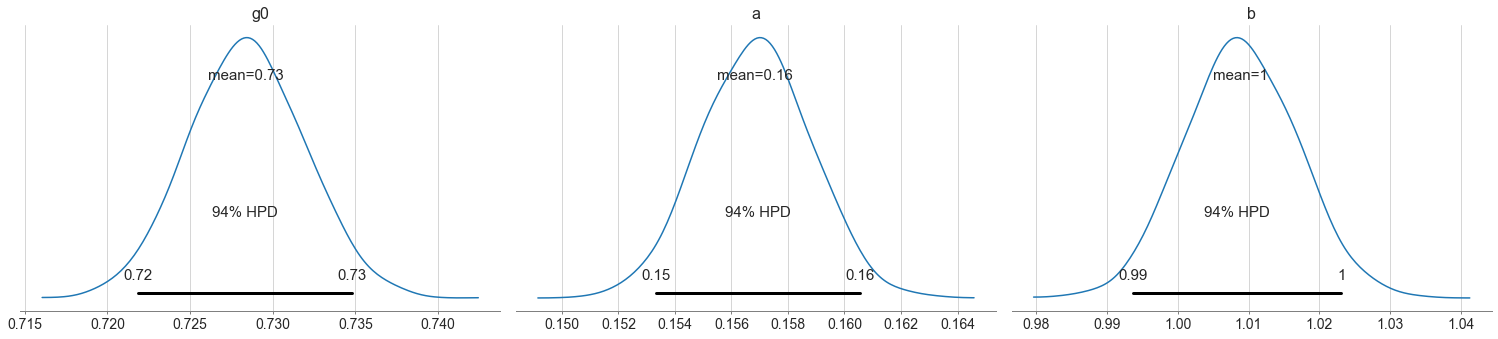

In [7]:
pm.plot_posterior(m1.trace, var_names=['g0', 'a', 'b'])
None

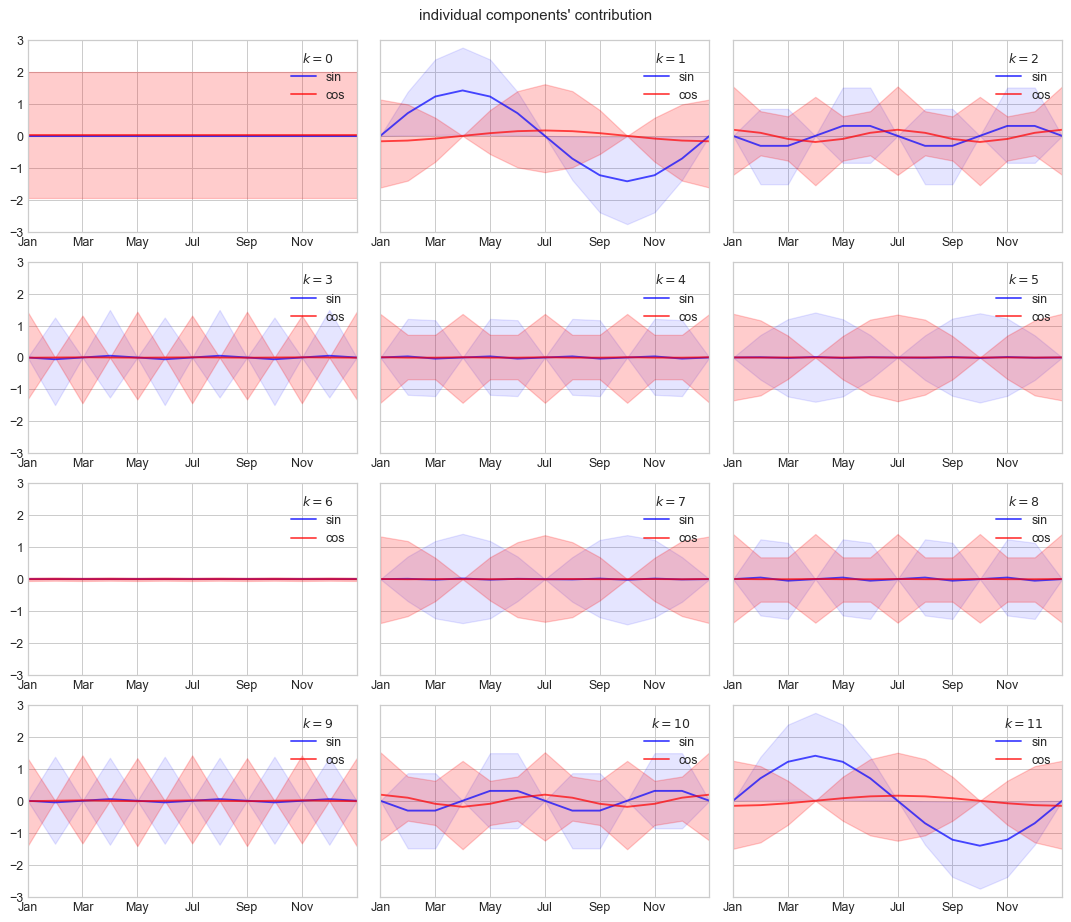

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(12, 10), dpi=90, sharey=True)
axes = axes.reshape(-1)

for i, (k, ax) in enumerate(zip(range(12), axes)):
    tr = pd.DataFrame(m1.trace['components'][:, 2*i, :]).apply(summarize()).T
    ax.plot(tr.mean_, label='sin', color='b', alpha=.7)
    ax.fill_between(tr.index, tr.lower, tr.upper,
                    alpha=.1, color='b', label='')
    tr = pd.DataFrame(m1.trace['components'][:, 2*i+1, :]).apply(summarize()).T
    ax.plot(tr.mean_, label='cos', color='r', alpha=.7)
    ax.fill_between(tr.index, tr.lower, tr.upper,
                    alpha=.2, color='r', label='')
    ax.legend(title=f'$k={k}$')
    ax.set(xlim=(0, 12), ylim=(-3, 3),
           xticklabels=[calendar.month_abbr[i] for i in range(1, 13, 2)])

fig.tight_layout()
fig.suptitle("individual components' contribution", y=1.02)
None

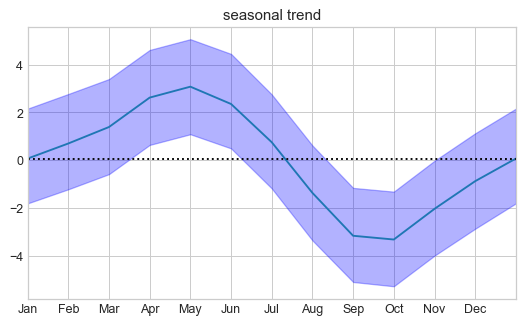

In [9]:
tmp = pd.DataFrame(m1.trace['p']).apply(summarize()).T
plt.figure(figsize=(7, 4), dpi=90)
plt.plot(tmp.mean_)
plt.fill_between(tmp.index, tmp.lower, tmp.upper, alpha=.3, color='b')
plt.axhline(tmp.mean_[0], linestyle=':', color='k')
plt.gca().set(xlim=(0, 12), title='seasonal trend',
              xticks=range(0, 13),
              xticklabels=[calendar.month_abbr[i] for i in range(1, 13)])
None

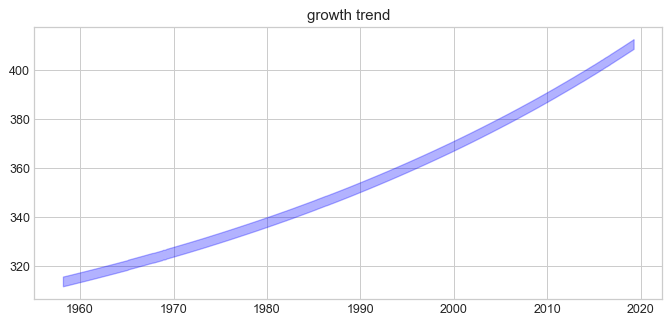

In [10]:
tmp = pd.DataFrame(m1.trace['g']).apply(summarize()).T

fig, ax = plt.subplots(1, 1, figsize=(9, 4), dpi=90)
ax.fill_between(data.date,
                data.CO2.mean() * tmp.lower,
                data.CO2.mean() * tmp.upper,
                alpha=.3, color='b')
ax.set(title='growth trend')
None

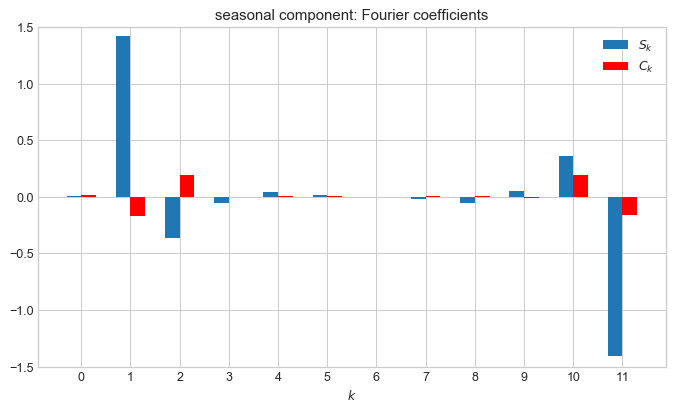

In [11]:
plt.figure(figsize=(9, 5), dpi=90)

tmps = pd.DataFrame(m1.trace['sk']).apply(summarize()).T
tmpc = pd.DataFrame(m1.trace['ck']).apply(summarize()).T

plt.bar(tmps.index - .15, tmps.mean_, width=.3, label='$S_k$')
plt.bar(tmpc.index + .15, tmpc.mean_, width=.3, color='r', label='$C_k$')
plt.gca().set(xticks=range(12), xlabel='$k$', ylim=(-1.5, 1.5),
              title='seasonal component: Fourier coefficients')
plt.legend()

None

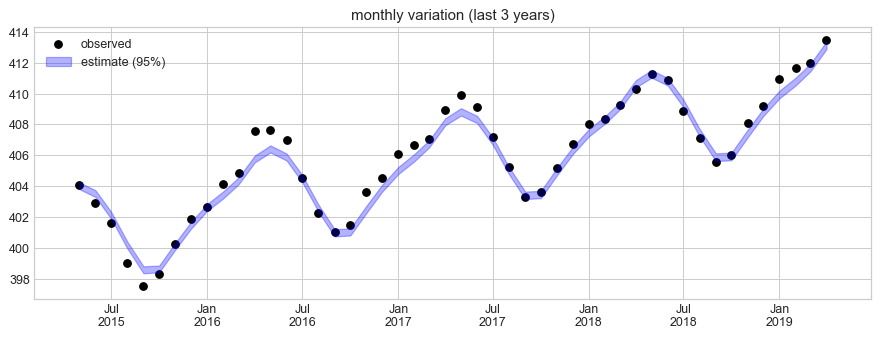

In [12]:
tmp = pd.DataFrame(m1.trace['co2'][:, -48:]).apply(summarize()).T
plt.figure(figsize=(12, 4), dpi=90)
plt.scatter(data.date[-48:], data.CO2[-48:],
            label='observed', c='k')
plt.fill_between(data.date[-48:], tmp.lower, tmp.upper,
                 alpha=.3, color='b', label='estimate (95%)')
plt.gca().set(title='monthly variation (last 3 years)')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b\n%Y'))
plt.legend()
None

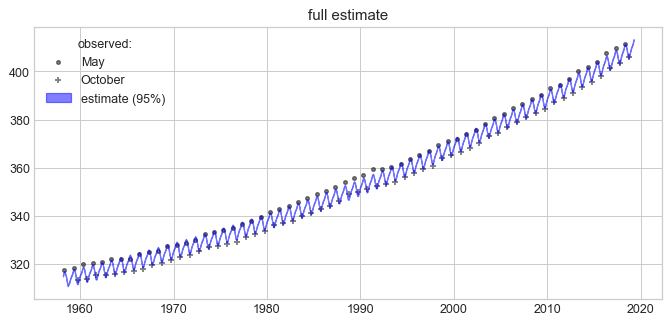

In [13]:
tmp = pd.DataFrame(m1.trace['co2']).apply(summarize()).T
plt.figure(figsize=(9, 4), dpi=90)
plt.scatter(data[data.month == 5].date, data[data.month == 5].CO2,
            marker='.', alpha=.5, color='k', label='May')
plt.scatter(data[data.month == 10].date, data[data.month == 10].CO2,
            marker='+', s=19, alpha=.5, color='k', label='October')
plt.fill_between(data.date, tmp.lower, tmp.upper,
                 alpha=.5, color='b', label='estimate (95%)')
plt.gca().set(title='full estimate')
plt.legend(title='observed:')
None